In [ ]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/emotion-detection-fer


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Image settings
img_size = 48
batch_size = 64

# Data generators
train_dir = path + '/train'
test_dir = path + '/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode='categorical'
)

# Build a simple CNN
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 1)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(0.5),
    layers.Dense(7, activation='softmax')  # 7 emotions: angry, disgust, fear, happy, sad, surprise, neutral
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_emotion_model.keras', monitor='val_accuracy', save_best_only=True)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
130/449 ━━━━━━━━━━━━━━━━━━━━ 1:47 338ms/step - accuracy: 0.2045 - loss: 1.8828

In [ ]:
model.save('emotion_detection_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
Predicted Emotion: Angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Emotion: Happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Emotion: Neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Emotion: Happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Emotion: Angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Emotion: Happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted Emotion: Happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Emotion: Neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Emotion: Surprise


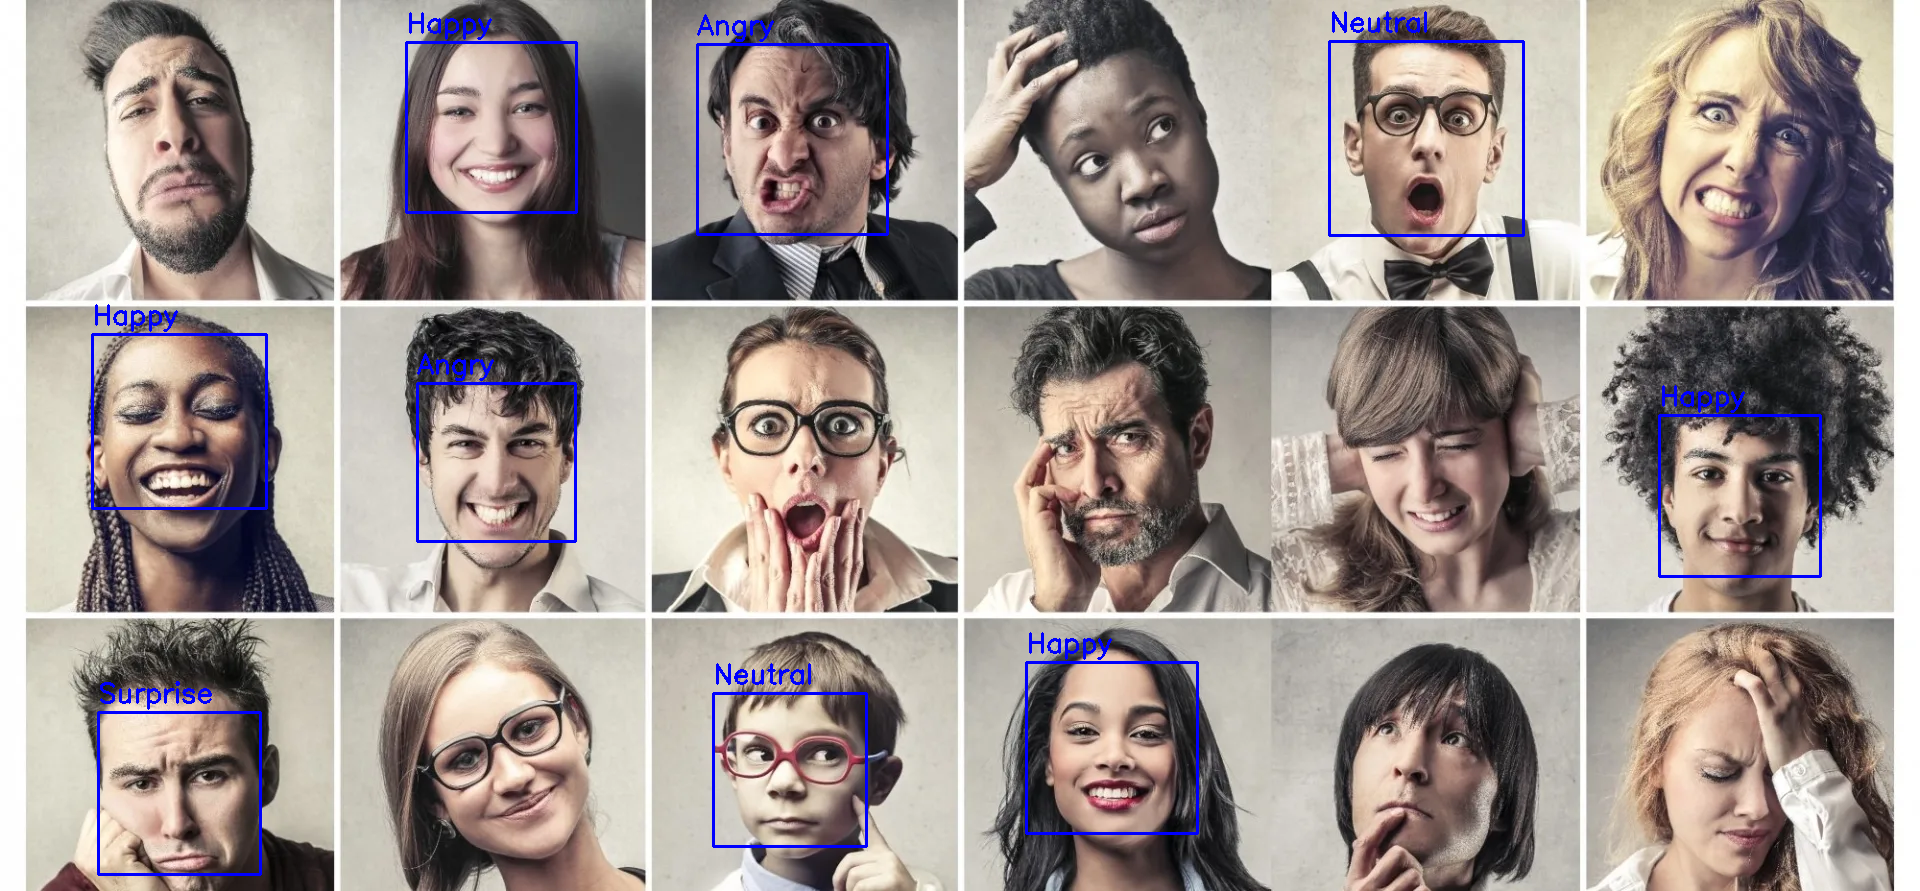

In [ ]:
model.save('emotion_detection_model.keras')
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('emotion_detection_model.h5')  # Replace with your model file

# Emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Load an image
img = cv2.imread('/content/qwe.webp')  # Replace with your image file name
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect face (optional) or use whole image
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_classifier.detectMultiScale(gray, 1.3, 5)

for (x, y, w, h) in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_gray = cv2.resize(roi_gray, (48, 48))
    roi_gray = roi_gray.astype('float') / 255.0
    roi_gray = np.expand_dims(roi_gray, axis=0)
    roi_gray = np.expand_dims(roi_gray, axis=-1)

    prediction = model.predict(roi_gray)
    label = emotion_labels[np.argmax(prediction)]

    print(f"Predicted Emotion: {label}")

    # Draw on image
    cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
    cv2.putText(img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)

# Show the image with prediction
cv2_imshow(img)  # Use cv2_imshow instead of cv2.imshow


In [ ]:
import cv2
import numpy as np

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

try:
    while True:
        ret, frame = cap.read()

        # Check if frame is successfully read
        if not ret:
            print("Error: Could not read frame from camera.")
            break  # Exit the loop if frame is not read

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_classifier.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_gray = cv2.resize(roi_gray, (img_size, img_size))
            roi_gray = roi_gray.astype('float')/255.0
            roi_gray = np.expand_dims(roi_gray, axis=0)
            roi_gray = np.expand_dims(roi_gray, axis=-1)

            prediction = model.predict(roi_gray)
            label = emotion_labels[np.argmax(prediction)]

            cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0), 2)
            cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)

        cv2.imshow('Emotion Detector', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    cap.release()
    # Try to destroy all windows, but ignore the error if it occurs
    try:
        cv2.destroyAllWindows()
    except cv2.error:
        pass